In [1]:
import random
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import xarray

from tqdm import tqdm as tqdm
from brainscore.metrics import Score
from brainscore.assemblies import walk_coords
from scipy.stats import pearsonr
from src.results.experiments import *
from src.results.experiments import _DateExperimentLoader
from sklearn.linear_model import LinearRegression,Ridge,RidgeCV

from scipy.stats import gaussian_kde
from scipy.stats import norm
from brainscore.metrics.correlation import Correlation, CrossCorrelation
from brainscore.metrics.regression import pearsonr_correlation,CrossRegressedCorrelation,pls_regression,linear_regression
from brainscore.metrics.behavior import I2n
from brainscore.assemblies import split_assembly
from brainio_base.assemblies import DataAssembly

from sklearn.model_selection import train_test_split

Using TensorFlow backend.


# Load Brainscore according to DiCarlo Lab [directions](https://github.com/brain-score/brain-score/blob/master/examples/data.ipynb):

In [2]:
import brainscore
neural_data = brainscore.get_assembly(name="dicarlo.Majaj2015")
neural_data.load()
stimulus_set = neural_data.attrs['stimulus_set']

/home/elijahc/.pyenv/versions/fastai/lib/python3.6/site-packages/brainio_base/assemblies.py:213: FutureWarning: The inplace argument has been deprecated and will be removed in a future version of xarray.
  xr_data.set_index(append=True, inplace=True, **coords_d)


(1) select only hard images with a variation of 6,

(2) average across repetitions,

(3) get rid of the scalar time_bin dimension,

(4) and reshape into presentation x neuroid.

In [3]:
def process_dicarlo(assembly,avg_repetition=True,variation=3,tasks=['ty','tz','rxy']):
    stimulus_set = assembly.attrs['stimulus_set']
    stimulus_set['dy_deg'] = stimulus_set.tz*stimulus_set.degrees
    stimulus_set['dx_deg'] = stimulus_set.ty*stimulus_set.degrees
    stimulus_set['dy_px'] = stimulus_set.dy_deg*32
    stimulus_set['dx_px'] = stimulus_set.dx_deg*32
    
    assembly.attrs['stimulus_set'] = stimulus_set
    
    data = assembly.sel(variation=variation)
    groups = ['category_name', 'object_name', 'image_id']+tasks
    if not avg_repetition:
        groups.append('repetition')
        
    data = data.multi_groupby(groups)     # (2)
    data = data.mean(dim='presentation')
    data = data.squeeze('time_bin')    #   (3)
    data.attrs['stimulus_set'] = stimulus_set.query('variation == {}'.format(variation))
    data = data.T
    
    return data

In [4]:
med_data = process_dicarlo(neural_data)
hi_data = process_dicarlo(neural_data,variation=6)
# lo_data = process_dicarlo(neural_data,variation=0)
v4_med = med_data.sel(region='V4')
it_med = med_data.sel(region='IT')

v4_hi = hi_data.sel(region='V4')
it_hi = hi_data.sel(region='IT')

/home/elijahc/.pyenv/versions/fastai/lib/python3.6/site-packages/brainio_base/assemblies.py:247: FutureWarning: The inplace argument has been deprecated and will be removed in a future version of xarray.
  result.reset_index(self.multi_group_name, drop=True, inplace=True)
/home/elijahc/.pyenv/versions/fastai/lib/python3.6/site-packages/brainio_base/assemblies.py:248: FutureWarning: The inplace argument has been deprecated and will be removed in a future version of xarray.
  result.set_index(append=True, inplace=True, **{self.multi_group_name: self.group_coord_names})


In [5]:
med_data

<xarray.NeuronRecordingAssembly 'dicarlo.Majaj2015' (presentation: 2560, neuroid: 296)>
array([[ 0.1962  ,  0.10559 ,  0.430899, ..., -0.12371 , -0.037532, -0.496546],
       [-0.188017, -0.599624, -0.02469 , ..., -0.267518, -0.48043 , -0.494902],
       [ 0.576654,  0.242336, -0.229085, ..., -0.161467, -0.120686, -0.097175],
       ...,
       [ 0.608051,  0.17681 , -0.110604, ...,  0.05714 , -0.227275, -0.254021],
       [ 0.014948, -0.243371, -0.238544, ..., -0.418934, -0.063361, -0.075867],
       [-0.107264, -0.029414, -0.074609, ..., -0.267031, -0.267418, -0.112186]],
      dtype=float32)
Coordinates:
  * neuroid        (neuroid) MultiIndex
  - neuroid_id     (neuroid) object 'Chabo_L_M_5_9' ... 'Chabo_L_P_7_6'
  - arr            (neuroid) object 'M' 'M' 'M' 'M' 'M' ... 'P' 'P' 'P' 'P' 'P'
  - col            (neuroid) int64 9 9 8 9 8 8 7 7 5 6 4 ... 8 7 8 6 7 5 7 7 6 6
  - hemisphere     (neuroid) object 'L' 'L' 'L' 'L' 'L' ... 'L' 'L' 'L' 'L' 'L'
  - subregion      (neuroid) obj

# Load Our Experiments
- Lg Feedforward (2019-06-03)
    - (3000,2000,500,70)
- Sm Feedforward (2019-05-24)
    - (3000,2000,500,15)
- Convolutional

In [6]:
# lg_ff = _DateExperimentLoader('2019-06-25')
lg_ff = _DateExperimentLoader('2019-06-03')
# sm_ff = _DateExperimentLoader('2019-05-24')
lg_ff.load()

In [30]:
lg_xent = lg_ff.assemblies[0]
lg_both = lg_ff.assemblies[1]
lg_recon = lg_ff.assemblies[2]

In [8]:
lg_xent

<xarray.DataAssembly (presentation: 10000, neuroid: 8706)>
array([[  0.      ,   0.      ,   0.      , ...,  -1.803094,  -1.517236,
          0.429822],
       [  0.      ,   0.      ,   0.      , ...,  14.268075,   7.881641,
          1.522919],
       [  0.      ,   0.      ,   0.      , ..., 190.44424 ,  69.854935,
         38.810143],
       ...,
       [  0.      ,   0.      ,   0.      , ...,   7.791061,   9.561553,
         27.46015 ],
       [  0.      ,   0.      ,   0.      , ...,  98.403114,  13.28393 ,
         59.213852],
       [  0.      ,   0.      ,   0.      , ...,   1.947304,  -5.430542,
          1.04232 ]], dtype=float32)
Coordinates:
  * presentation   (presentation) MultiIndex
  - image_id       (presentation) object '341132b689be385231f6b7de0cc54797' ... '4ed434b08dcdba180dcdfdaf1c121b04'
  - object_name    (presentation) object 'Ankle boot' 'Pullover' ... 'Dress'
  - dx             (presentation) float64 7.0 5.0 0.0 8.0 ... 1.0 9.0 -1.0 -2.0
  - dy             

In [9]:
from brainscore.assemblies import split_assembly

In [10]:
from sklearn.linear_model import LinearRegression,Ridge

In [11]:
alphas = tuple(np.logspace(-2,2,num=10))

In [12]:
est = RidgeCV(alphas=alphas,store_cv_values=True)
tr,te = split_assembly(med_data.sel(region='IT'))

In [13]:
est.fit(tr.values,y=tr['tz'])

RidgeCV(alphas=array([1.00000000e-02, 2.78255940e-02, 7.74263683e-02, 2.15443469e-01,
       5.99484250e-01, 1.66810054e+00, 4.64158883e+00, 1.29154967e+01,
       3.59381366e+01, 1.00000000e+02]),
        cv=None, fit_intercept=True, gcv_mode=None, normalize=False,
        scoring=None, store_cv_values=True)

In [14]:
print(est.alpha_)
est.cv_values_.mean(axis=0)

35.93813663804626


array([0.05472801, 0.05472482, 0.05471599, 0.05469167, 0.05462587,
       0.05445639, 0.05407375, 0.05346653, 0.05327844, 0.05513851])

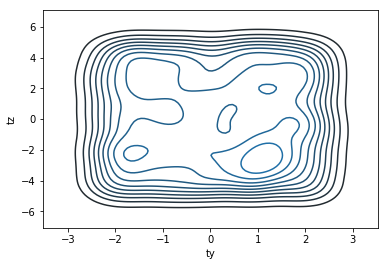

In [15]:
sns.kdeplot(med_data.ty*8,med_data.tz*8)

In [16]:
def SUCorrelation(da,neuroid_coord,correlation_vars,exclude_zeros=True):
    if exclude_zeros:
        nz_neuroids = da.groupby(neuroid_coord).sum('presentation').values!=0
        da = da[:,nz_neuroids]
    
    correlations = np.empty((len(da[neuroid_coord]),len(correlation_vars)))
    for i,nid in tqdm(enumerate(da[neuroid_coord].values),total=len(da[neuroid_coord])):
        for j,prop in enumerate(correlation_vars):
            n_act = da.sel(**{neuroid_coord:nid}).squeeze()
            r,p = pearsonr(n_act,prop)
            correlations[i,j] = np.abs(r)

    neuroid_dim = da[neuroid_coord].dims
    c = {coord: (dims, values) for coord, dims, values in walk_coords(da) if dims == neuroid_dim}
    c['task']=('task',[v.name for v in correlation_vars])
#     print(neuroid_dim)
    result = Score(correlations,
                       coords=c,
                       dims=('neuroid','task'))
    return result

def result_to_df(SUC,corr_var_labels):
    df = SUC.neuroid.to_dataframe().reset_index()
    for label in corr_var_labels:
        df[label]=SUC.sel(task=label).values
    
    return df

class MURegressor(object):
    def __init__(self,da,train_frac=0.8,n_splits=5,n_units=None,estimator=Ridge):
        if n_units is not None:
            self.neuroid_idxs = [np.array([random.randrange(len(da.neuroid_id)) for _ in range(n_units)]) for _ in range(n_splits)]
        
        self.original_data = da
        self.train_frac = train_frac
        self.n_splits = n_splits
        
        splits = [split_assembly(self.original_data[:,n_idxs]) for n_idxs in tqdm(self.neuroid_idxs,total=n_splits,desc='CV-splitting')]
        self.train = [tr for tr,te in splits]
        self.test = [te for tr,te in splits]
        
        
        self.estimators = [estimator() for _ in range(n_splits)]
        
    def fit(self,y_coord):
        # Get Training data
        for mod,train in tqdm(zip(self.estimators,self.train),total=len(self.train),desc='fitting'):
#             print(train)
            mod.fit(X=train.values,y=train[y_coord])
    
        return self
    
    def predict(self,X=None):
        if X is not None:
            return [e.predict(X) for e in self.estimators]
        else:
            return [e.predict(te.values) for e,te in zip(self.estimators,self.test)]
        
    def score(self,y_coord):
        return [e.score(te.values,te[y_coord].values) for e,te in zip(self.estimators,self.test)]

In [17]:
def stratified_regressors(data, filt='region',n_units=126,y_coords=['ty','tz'],task_names=None,estimator=Ridge):
    subsets = np.unique(data[filt].values)
    if task_names is None:
        task_names = y_coords
    dfs = []
    for y,task in zip(y_coords,task_names):
        print('regressing {}...'.format(y))
        regressors = {k:MURegressor(data.sel(**{filt:k}),n_units=n_units,estimator=Ridge).fit(y_coord=y) for k in subsets}
        df = pd.DataFrame.from_records({k:v.score(y_coord=y) for k,v in regressors.items()})
        df = df.melt(var_name='region',value_name='performance')
        df['task']=task
        dfs.append(df)
    
    return pd.concat(dfs)

In [18]:
hi_df = stratified_regressors(hi_data,y_coords=['ty','tz','rxy'],n_units=100,
#                               task_names=['tx','ty','rxy'],
                              estimator=RidgeCV)
med_df = stratified_regressors(med_data, y_coords=['ty','tz','rxy'],n_units=100,
#                                task_names=['tx','ty','rxy'],
                               estimator=RidgeCV)

regressing ty...


fitting: 100%|██████████| 5/5 [00:00<00:00, 207.24it/s]


regressing tz...


fitting: 100%|██████████| 5/5 [00:00<00:00, 135.06it/s]


regressing rxy...


fitting: 100%|██████████| 5/5 [00:00<00:00, 204.84it/s]


regressing ty...


fitting: 100%|██████████| 5/5 [00:00<00:00, 145.96it/s]


regressing tz...


fitting: 100%|██████████| 5/5 [00:00<00:00, 147.52it/s]


regressing rxy...


fitting: 100%|██████████| 5/5 [00:00<00:00, 144.14it/s]


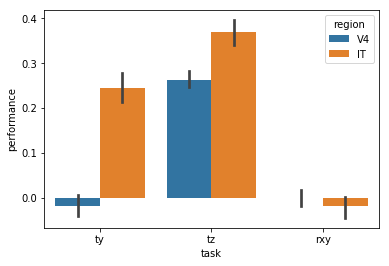

In [19]:
sns.barplot(x='task',y='performance',hue='region',hue_order=['V4','IT'],data=med_df)

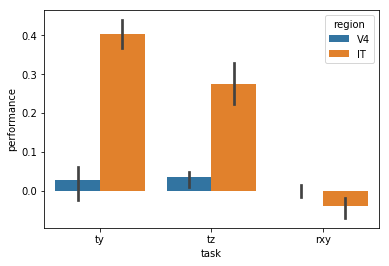

In [20]:
sns.barplot(x='task',y='performance',hue='region',hue_order=['V4','IT'],data=hi_df)

In [21]:
lg_both_top = lg_both[:,lg_both.layer.isin([2,3,4])]

In [22]:
both_df = stratified_regressors(lg_both,filt='layer',y_coords=['tx','ty','rxy'],n_units=50)

regressing tx...


fitting:   0%|          | 0/5 [00:00<?, ?it/s]/home/elijahc/.pyenv/versions/fastai/lib/python3.6/site-packages/sklearn/linear_model/ridge.py:147: LinAlgWarning: Ill-conditioned matrix (rcond=6.91917e-09): result may not be accurate.
  overwrite_a=True).T
/home/elijahc/.pyenv/versions/fastai/lib/python3.6/site-packages/sklearn/linear_model/ridge.py:147: LinAlgWarning: Ill-conditioned matrix (rcond=6.95389e-09): result may not be accurate.
  overwrite_a=True).T
/home/elijahc/.pyenv/versions/fastai/lib/python3.6/site-packages/sklearn/linear_model/ridge.py:147: LinAlgWarning: Ill-conditioned matrix (rcond=3.41264e-09): result may not be accurate.
  overwrite_a=True).T
/home/elijahc/.pyenv/versions/fastai/lib/python3.6/site-packages/sklearn/linear_model/ridge.py:147: LinAlgWarning: Ill-conditioned matrix (rcond=6.9848e-09): result may not be accurate.
  overwrite_a=True).T
fitting: 100%|██████████| 5/5 [00:00<00:00, 54.09it/s]


regressing ty...


fitting:   0%|          | 0/5 [00:00<?, ?it/s]/home/elijahc/.pyenv/versions/fastai/lib/python3.6/site-packages/sklearn/linear_model/ridge.py:147: LinAlgWarning: Ill-conditioned matrix (rcond=6.52838e-09): result may not be accurate.
  overwrite_a=True).T
/home/elijahc/.pyenv/versions/fastai/lib/python3.6/site-packages/sklearn/linear_model/ridge.py:147: LinAlgWarning: Ill-conditioned matrix (rcond=3.5014e-09): result may not be accurate.
  overwrite_a=True).T
/home/elijahc/.pyenv/versions/fastai/lib/python3.6/site-packages/sklearn/linear_model/ridge.py:147: LinAlgWarning: Ill-conditioned matrix (rcond=9.22525e-09): result may not be accurate.
  overwrite_a=True).T
fitting: 100%|██████████| 5/5 [00:00<00:00, 54.56it/s]


regressing rxy...


fitting:   0%|          | 0/5 [00:00<?, ?it/s]


KeyError: 'rxy'

In [ ]:
# lg_xent_top = lg_xent[:,lg_xent.layer.isin([2,3,4])]
xent_df = stratified_regressors(lg_xent,filt='layer',y_coords=['tx','ty','rxy'],n_units=50)

In [ ]:
both_df.head()

In [ ]:
sns.boxplot(x='task',y='performance',hue='region',data=both_df)

In [ ]:
sns.boxplot(x='task',y='performance',hue='region',data=xent_df)

In [ ]:
both_regressors

In [ ]:
med_v4_MUR.score(y_coord='ty')

In [ ]:
[(tr.shape,te.shape) for tr,te in med_MUR_dicarlo.splits]
[n for n in med_MUR_dicarlo.neuroid_idxs]

In [28]:
properties = ['tx','ty',
#               'rxy',
             ]

In [24]:
corr_vars_both = [pd.Series(lg_both[v].values,name=v) for v in ['tx','ty']]
corr_both = SUCorrelation(lg_both,neuroid_coord='neuroid_id',correlation_vars=corr_vars_both)

100%|██████████| 7086/7086 [01:24<00:00, 83.45it/s]
/home/elijahc/.pyenv/versions/fastai/lib/python3.6/site-packages/brainio_base/assemblies.py:213: FutureWarning: The inplace argument has been deprecated and will be removed in a future version of xarray.
  xr_data.set_index(append=True, inplace=True, **coords_d)


In [25]:
corr_vars_xent = [pd.Series(lg_xent[v].values,name=v) for v in ['tx','ty']]
corr_xent = SUCorrelation(lg_xent,neuroid_coord='neuroid_id',correlation_vars=corr_vars_xent)

100%|██████████| 5940/5940 [01:10<00:00, 84.80it/s]


In [31]:
corr_vars_recon = [pd.Series(lg_recon[v].values,name=v) for v in properties]
corr_recon = SUCorrelation(lg_recon,neuroid_coord='neuroid_id',correlation_vars=corr_vars_recon)

100%|██████████| 7074/7074 [01:24<00:00, 83.38it/s]


In [ ]:
dicarlo_hi_corr_vars = [
    pd.Series(hi_data['ty'],name='tx'),
    pd.Series(hi_data['tz'],name='ty'),
    pd.Series(hi_data['rxy'],name='rxy'),
]
corr_dicarlo_hi = SUCorrelation(hi_data,neuroid_coord='neuroid_id',correlation_vars=dicarlo_hi_corr_vars,exclude_zeros=True)

dicarlo_med_corr_vars = [
    pd.Series(med_data['ty'],name='tx'),
    pd.Series(med_data['tz'],name='ty'),
    pd.Series(med_data['rxy'],name='rxy'),

]
corr_dicarlo_med = SUCorrelation(med_data,neuroid_coord='neuroid_id',correlation_vars=dicarlo_med_corr_vars,exclude_zeros=True)


# dicarlo_lo_corr_vars = [
#     pd.Series(lo_data['ty'],name='tx'),
#     pd.Series(lo_data['tz'],name='ty'),
# ]
# corr_dicarlo_lo = SUCorrelation(lo_data,neuroid_coord='neuroid_id',correlation_vars=dicarlo_lo_corr_vars,exclude_zeros=True)



In [ ]:
dicarlo_med_df = result_to_df(corr_dicarlo_med,['tx','ty','rxy'])
dicarlo_med_df['variation']=3

dicarlo_hi_df = result_to_df(corr_dicarlo_hi,['tx','ty','rxy'])
dicarlo_hi_df['variation']=6

# dicarlo_lo_df = result_to_df(corr_dicarlo_lo,['tx','ty'])
# dicarlo_lo_df['variation']=0
# dicarlo_lo_df['norm_ty'] = dicarlo_lo_df['ty']

# dicarlo_df = pd.concat([dicarlo_hi_df,dicarlo_med_df])
# dicarlo_df['norm_ty'] = dicarlo_df['ty']/2

# dicarlo_df = pd.concat([dicarlo_df,dicarlo_lo_df])

In [41]:
both_df = result_to_df(corr_both,['tx','ty'])
both_df['norm_ty'] = both_df.ty

xent_df = result_to_df(corr_xent,['tx','ty'])
xent_df['norm_ty'] = xent_df.ty

recon_df = result_to_df(corr_recon,['tx','ty'])
recon_df['norm_ty'] = recon_df.ty

In [37]:
def plot_kde(x,y,df,by='region',order=None):
    if order is not None:
        subsets = order
    else:
        subsets = df[by].drop_duplicates().values
        
    plot_scale = 5
    fig,axs = plt.subplots(1,len(subsets),figsize=(plot_scale*len(subsets),plot_scale),sharex=True,sharey=True,
                           subplot_kw={
                               'xlim':(0.0,0.8),
                               'ylim':(0.0,0.8)
                           })
    
    for ax,sub in zip(axs,subsets):
        sub_df = df.query('{} == "{}"'.format(by,sub))
        sns.kdeplot(sub_df[x],sub_df[y],ax=ax)
        ax.set_title("{}: {}".format(by,sub))

In [36]:
# med_data

In [52]:
def plot_bars(y,df,by='region',order=None):
    if order is not None:
        subsets = order
    else:
        subsets = df[by].drop_duplicates().values
        
    plot_scale = 5
    fig,axs = plt.subplots(1,len(subsets),figsize=(plot_scale*len(subsets),plot_scale),sharex=True,sharey=True,
                           subplot_kw={
                               'xlim':(0.0,0.8),
                               'ylim':(0.0,0.8)
                           })
    
    for ax,sub in zip(axs,subsets):
        subsets = df[by].drop_duplicates().values
        sub_df = df.query('{} == "{}"'.format(by,sub))
        sns.barplot(x=by,y=y,ax=ax)

# plot_bars(y='tx',df=both_df,by='layer',order=np.arange(5))

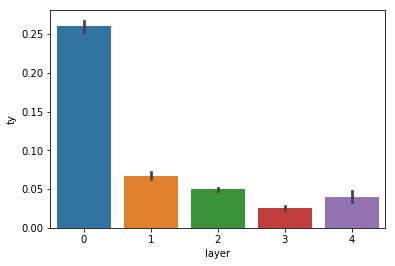

In [56]:
sns.barplot(x='layer',y='ty',data=xent_df)

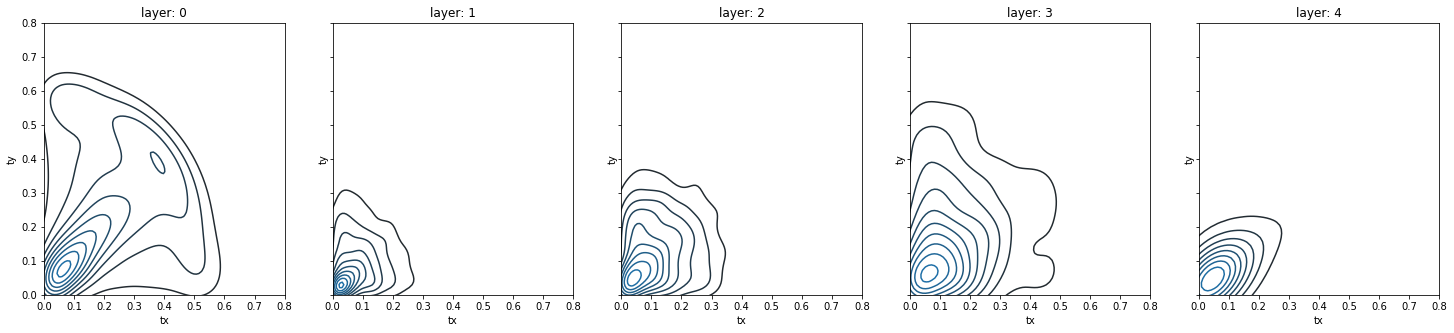

In [38]:
plot_kde('tx','ty',both_df,by='layer',order=np.arange(5))

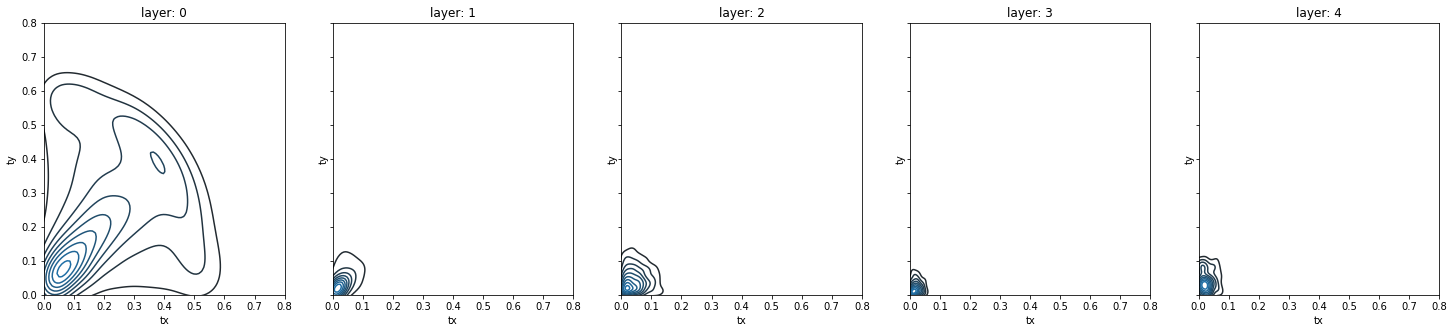

In [39]:
plot_kde('tx','ty',xent_df,by='layer',order=np.arange(5))

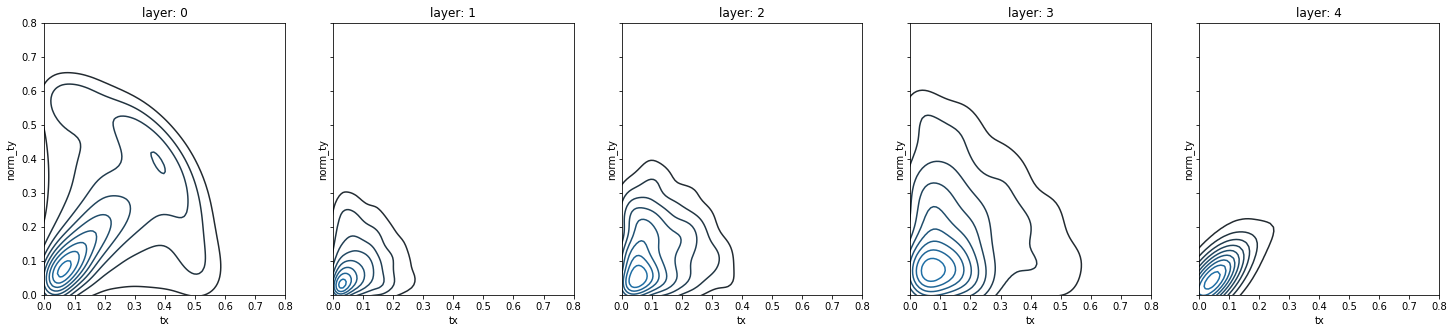

In [43]:
plot_kde('tx','norm_ty',recon_df,by='layer',order=np.arange(5))

In [ ]:
sns.set_context('talk')
plot_kde('tx','ty',dicarlo_df.query('variation == 6'),by='region',order=['V4','IT'])

In [ ]:
plot_kde('tx','ty',dicarlo_df.query('variation == 3'),by='region',order=['V4','IT'])

In [ ]:
# g = corr.groupby('region')

# corr_res = corr.reindex(task=corr.task,neuroid=corr.neuroid_id)
corr= corr.name='both'
corr.reset_coords()

# g.groups
# for l,grp in g:
#     res_grp = grp.dropna('neuroid')
#     res_grp.name=label
#     res_grp = res_grp.reindex(task=res_grp.task,neuroid=res_
#     print(res_grp)
#     res_grp.to_dataframe(name='label').head()

In [ ]:
g = corr.dropna(dim='neuroid').reset_index(corr.dims).groupby('region')
for label,group in g:
    agg_dfs.append(group.reset_index(group.dims).to_dataframe(name='label'))

In [ ]:
corr_dicarlo

In [ ]:
lg.groupby('neuroid_id').groups

In [ ]:
from scipy.stats import pearsonr,pearson3

class XArraySUCorrelation(object):
    def __init__(self,assembly,stimulus_coords='tx',neuroid_coord='neuroid_id',func=pearsonr):
        self.stimulus_coord = stimulus_coord
        self.func = func
        
        

In [ ]:
pearsonr()

In [ ]:
# compact_data = data.multi_groupby(['category_name', 'object_name', 'image_id'])
# compact_data = compact_data.mean(dim='presentation')
# compact_data = compact_data.squeeze('time_bin')  # (3)

In [ ]:

# compact_data = compact_data.T  # (4)

In [ ]:
# stimulus_set['y_pix'] = scaler.fit_transform(stimulus_set.ty.values.reshape(-1,1))
# stimulus_set['z_pix'] = scaler.fit_transform(stimulus_set.tz.values.reshape(-1,1))

stimulus_set.head()

In [ ]:
tx = stimulus_set.query('variation == 6')
tx[['ty','tz','x','y','x_px','y_px']].describe()

In [ ]:
sns.kdeplot(tx.ty,tx.tz,shade=True)

In [ ]:
sns.scatterplot(v4_resp.x,v4_resp.y)

In [ ]:
from matplotlib import image

def resp_dist(dat, presentation = None):
    fig, axs = plt.subplots(1,2,figsize=(10,5))
    if presentation is None:
        presentation = random.randrange(dat.values.shape[1])
    
    d = dat[:,presentation]
    cat_name, obj_name, image_id, tz, ty = d.presentation.values.tolist()
    image_path = stimulus_set.get_image(image_id)
    props = stimulus_set.query('image_id == "{}"'.format(image_id))
    g = sns.distplot(d.values,norm_hist=True,ax=axs[1])
    
    img = image.imread(image_path)
    axs[0].imshow(img)
    axs[0].set_title('{} tz:{} yz:{}'.format(obj_name, tz*8,ty*8))
    axs[0].scatter(props.x_px.values+128,props.y_px.values+128)
    print(props['image_file_name'].values)
    print(props[['ty','tz']])
    print(props[['x','y','x_px','y_px']])
    
    return g,props

g,props = resp_dist(v4_resp)
props

In [ ]:
x = neural_data.sel(variation=6)  # (1)
x = x.multi_groupby(['category_name', 'object_name', 'image_id','repetition','ty','tz'])  # (2)
x = x.mean(dim='presentation')
x = x.squeeze('time_bin')

In [ ]:
def xr_to_df(x):
    ty = x.tz.values
    tx = x.ty.values
    xdf = pd.DataFrame(x.values.T,columns=x.neuroid_id.values)
    xdf['class'] = x.object_name.values
    xdf['dy']=ty
    xdf['dx']=tx

    return xdf

In [ ]:
v4_resp.object_name.values

In [ ]:
from sklearn.multiclass import OneVsRestClassifier
from sklearn.svm import LinearSVC
from sklearn.model_selection import cross_val_score
from sklearn.preprocessing import MultiLabelBinarizer,LabelBinarizer

In [ ]:
clf = LinearSVC(C=1,max_iter=10000,verbose=1)
cross_val_score(clf,v4_resp.values.T,v4_resp.category_name.values,verbose=1,cv=5,n_jobs=5)

In [ ]:
v4_resp

In [ ]:
clf = LinearSVC(C=1,max_iter=10000,verbose=1)
cross_val_score(clf,IT_resp.values.T,IT_resp.category_name.values,verbose=1,cv=5,n_jobs=5)

In [ ]:


labels = v4_resp.object_name.values
labeler
for lab in np.unique(labels):
    LabelBinarizer().transform()

classifier = SVC(C=10)
# cross_val_score(classifier,v4_resp.values.T,v4_resp.object_name.values,cv=5,verbose=True)

In [ ]:
MultiLabelBinarizer()

In [ ]:
classifier.predict()

In [ ]:
v4 = x.sel(region='V4')
v4_df = xr_to_df(v4)

it = x.sel(region='IT')
it_df = xr_to_df(it)

In [ ]:
ds = xarray.open_dataset('/home/elijahc/projects/vae/models/2019-06-03/xent_15_recon_25/label_corruption_0.0/dataset.nc')

In [ ]:
da = ds['Only Recon']
da.coords.

In [ ]:
v4_x_sel = dicarlo_r(v4.values.T,prop=v4_df.dx)
v4_y_sel = dicarlo_r(v4.values.T,prop=v4_df.dy)

it_x_sel = dicarlo_r(it.values.T,prop=it_df.dx)
it_y_sel = dicarlo_r(it.values.T,prop=it_df.dy)

# v4_class_sel = dprime(v4_df,num_units=len(v4_resp.neuroid_id),col='class',mask_missing=False)

In [ ]:
v4_results = pd.DataFrame({
    'dx':v4_x_sel,
    'dy':v4_y_sel
})

In [ ]:
metric = CrossRegressedCorrelation(regression=pls_regression(),correlation=pearsonr_correlation())
v4_score = metric(v4,v4)

In [ ]:
v4_r

In [ ]:
v4_r.

In [ ]:
v4_df.head()

In [ ]:
# resp_dist(v4_resp,random_n=False)

In [ ]:
v4_resp

In [ ]:
image_path = stimulus_set.get_image(stimulus_set['image_id'][0])
print(image_path)